## Когортный анализ. Представление результатов

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine

In [2]:
db_config = {
    'user': 'praktikum_student', 
    'pwd': 'Sdf4$2;d-d30pp', 
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, 
    'db': 'data-analyst-advanced-sql'
} 

In [3]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [4]:
engine = create_engine(connection_string)

### Retention Rate

In [5]:
query = '''
WITH profile AS
  (SELECT user_id,
          dt,
          COUNT(*) OVER (PARTITION BY dt) AS cohort_users_cnt
   FROM online_store.profiles
   WHERE channel = 'Organic'),
sessions AS 
(SELECT user_id,
        session_start::date AS session_date
FROM online_store.sessions
GROUP BY 1,
         2)
SELECT p.dt AS cohort_dt,
       session_date,
       COUNT(p.user_id) AS users_cnt,
       cohort_users_cnt,
       ROUND(COUNT(p.user_id) * 100.0 / cohort_users_cnt, 2) AS retention_rate
FROM profile p
JOIN sessions s ON p.user_id = s.user_id
GROUP BY 1,
         2,
         4
'''

In [6]:
retention_rate_df = pd.read_sql_query(query, con = engine)

In [7]:
print(retention_rate_df.head())

    cohort_dt session_date  users_cnt  cohort_users_cnt  retention_rate
0  2020-06-14   2020-06-14       5098              5098          100.00
1  2020-06-14   2020-06-15       2647              5098           51.92
2  2020-06-14   2020-06-16       1836              5098           36.01
3  2020-06-14   2020-06-17       1403              5098           27.52
4  2020-06-14   2020-06-18       1085              5098           21.28


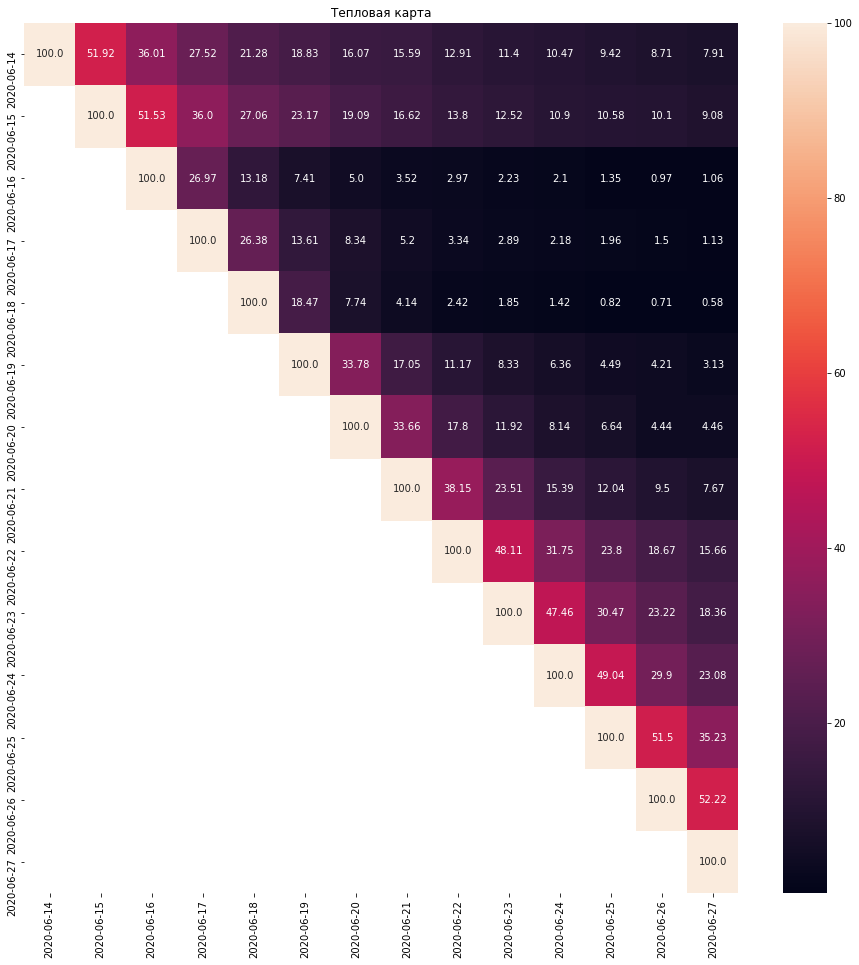

In [8]:
# создаем сводную таблицу с результатами
retention = retention_rate_df.pivot('cohort_dt', 'session_date', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

# строим хитмэп
plt.figure(figsize=(16, 16)) 
sns.heatmap(retention, 
            annot=True, 
            fmt='') 
plt.title('Тепловая карта') 
plt.show()

Самый маленький показатель Retention Rate в когорте пользователей, пришедших 18 июня. Среди пользователей когорт от 14, 15, 25 и 26 июня коэффициент удержания первого дня больше 50%.

### Churn Rate

Проанализируем данные когорт пользователей с января по июнь 2018 года. 

In [9]:
prof = '''
WITH profile AS
  (SELECT u.user_id,
          DATE_TRUNC('month', MIN(event_time))::date AS start_mn
   FROM tools_shop.users u
   JOIN tools_shop.orders o ON u.user_id = o.user_id
   JOIN tools_shop.events e ON u.user_id = e.user_id
   GROUP BY 1), 
sessions AS
  (SELECT start_mn,
          DATE_TRUNC('month', event_time)::date AS event_mn,
          COUNT(DISTINCT p.user_id) AS users_cnt
   FROM profile p
   JOIN tools_shop.events e ON p.user_id = e.user_id
   GROUP BY 1,
            2)
SELECT start_mn,
       event_mn,
       users_cnt,
       LAG(users_cnt) OVER (PARTITION BY start_mn ORDER BY event_mn) AS previous_day_users_cnt,
       ROUND((1 - (users_cnt::numeric / LAG(users_cnt) OVER (PARTITION BY start_mn ORDER BY event_mn))) * 100, 2) AS churn_rate
FROM sessions
WHERE start_mn BETWEEN '2018-01-01' AND '2018-06-01'
  AND event_mn BETWEEN '2018-01-01' AND '2018-12-01'
'''

In [10]:
churn_rate_dt = pd.read_sql_query(prof, con=engine)

In [11]:
print(churn_rate_dt.head())

     start_mn    event_mn  users_cnt  previous_day_users_cnt  churn_rate
0  2018-01-01  2018-01-01        257                     NaN         NaN
1  2018-01-01  2018-02-01         67                   257.0       73.93
2  2018-01-01  2018-03-01         41                    67.0       38.81
3  2018-01-01  2018-04-01         44                    41.0       -7.32
4  2018-01-01  2018-05-01         42                    44.0        4.55


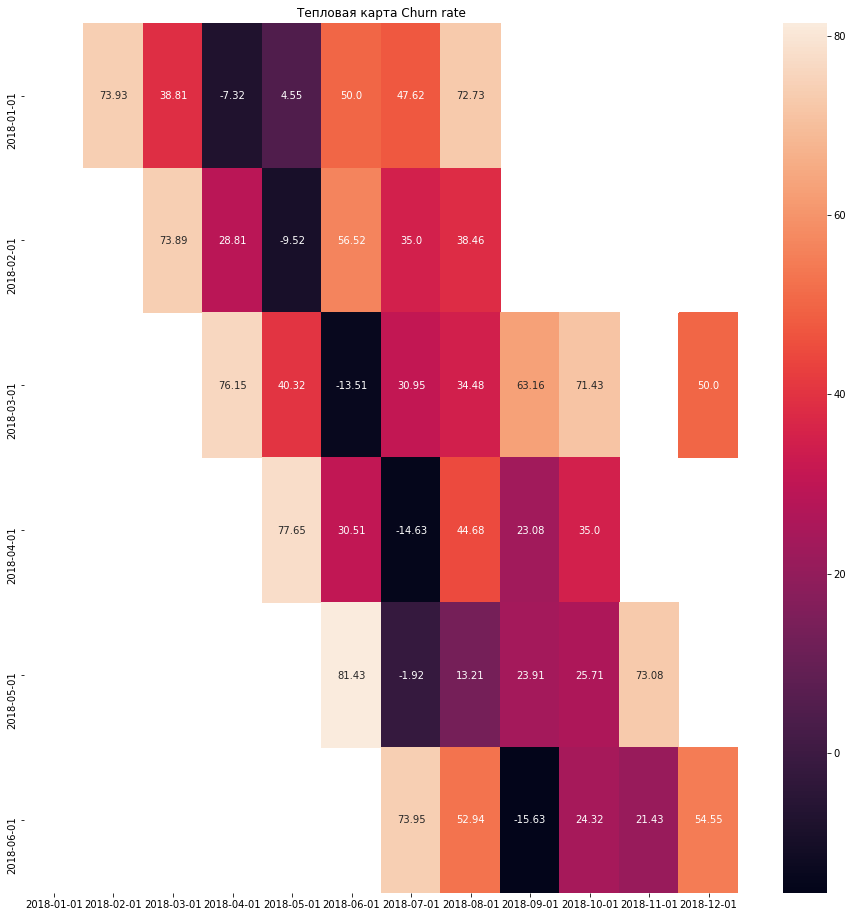

In [12]:
#создаем сводную таблицу с результатами
churn = churn_rate_dt.pivot('start_mn', 'event_mn', 'churn_rate')
churn.index = [str(x)[0:10] for x in churn.index]
churn.columns = [str(x)[0:10] for x in churn.columns]

#строим хитмэп
plt.figure(figsize=(16, 16))
sns.heatmap(churn,
           annot=True,
           fmt='')
plt.title('Тепловая карта Churn rate')
plt.show()

Самый большой отток в первый месяц в мае 2018 года. Во всех когортах в один месяц есть отрицательный отток. Наименьший отток пользователей во второй месяц в когорте май 2018.